In [93]:
#Basic libraries
import numpy as np
import pandas as pd
from scipy import stats
import textwrap as twp

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yellowbrick as yb
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches

# Statistics, EDA, metrics libraries
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, make_scorer, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox
import shap

# Modeling libraries
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import IsolationForest
import kmapper as km
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from collections import Counter
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from IPython.display import set_matplotlib_formats 
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks


# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[5], sns.color_palette(color)[0]]


In [94]:
df = pd.read_excel('/Users/Marta/Desktop/dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   AGE                                 1084 non-null   int64  
 1   OS_STATUS                           1084 non-null   int64  
 2   ANEUPLOIDY_SCORE                    1084 non-null   float64
 3   WINTER_HYPOXIA_SCORE                1084 non-null   float64
 4   MUTATION_COUNT                      1084 non-null   float64
 5   TUMOR_NECROSIS_PERCENT              1084 non-null   float64
 6   TUMOR_NUCLEI_PERCENT                1084 non-null   float64
 7   TUMOR_WEIGHT                        1084 non-null   float64
 8   CHEMOTHERAPY                        1084 non-null   int64  
 9   OTHER                               1084 non-null   int64  
 10  RADIATION THERAPY                   1084 non-null   int64  
 11  HORMONE THERAPY                     1084 no

In [95]:
X = df.drop(['OS_STATUS'], axis=1)
y = df['OS_STATUS']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Tree-random Forest

In [188]:
# create the object
rf =  RandomForestClassifier(class_weight='balanced_subsample')

rf_pipe = Pipeline(steps = [['scaler', StandardScaler()],
                                ['classifier', rf]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)

    
param_grid = {'classifier__n_estimators': Integer(1, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__max_features': Integer(1, 10),
              'classifier__min_samples_leaf': Integer(1, 10),
              'classifier__min_samples_split': Integer(2, 10)}



gs_rf = BayesSearchCV(estimator=rf_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_rf.fit(X_train, y_train)

results_rf = gs_rf.cv_results_
estimator_rf = gs_rf.best_estimator_

cv_score_rf = gs_rf.best_score_

y_predict_rf = estimator_rf.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_rf))
print('Roc auc scote:', roc_auc_score(y_predict_rf, y_test))
print('F1 core:',f1_score(y_predict_rf, y_test))
print('Precision score:', precision_score(y_test, y_predict_rf))
print('Recall score:', recall_score(y_test, y_predict_rf))
print(classification_report(y_test, y_predict_rf))
matrix_rf = pd.DataFrame(confusion_matrix(y_test, y_predict_rf),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_rf)

Accuracy is: 0.9032258064516129
Roc auc scote: 0.8280170122275385
F1 core: 0.5714285714285714
Precision score: 0.7368421052631579
Recall score: 0.4666666666666667
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       187
           1       0.74      0.47      0.57        30

    accuracy                           0.90       217
   macro avg       0.83      0.72      0.76       217
weighted avg       0.89      0.90      0.89       217

     pred_neg  pred_pos
neg       182         5
pos        16        14


In [189]:
test_score = gs_rf.best_estimator_.score(X_test, y_test)
train_score = gs_rf.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.9032258064516129 0.6672587634331283 0.9792387543252595


In [190]:
test_score = gs_rf.score(X_test, y_test)
train_score = gs_rf.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.7584415584415585 0.6672587634331283 0.9570744856419848


In [191]:
estimator = gs_rf.best_estimator_
estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ['classifier',
   RandomForestClassifier(ccp_alpha=0.004643096389492207,
                          class_weight='balanced_subsample', max_depth=15,
                          max_features=10, n_estimators=595)]],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': RandomForestClassifier(ccp_alpha=0.004643096389492207,
                        class_weight='balanced_subsample', max_depth=15,
                        max_features=10, n_estimators=595),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.004643096389492207,
 'classifier__class_weight': 'balanced_subsample',
 'classifier__criterion': 'gini',
 'classifier__max_depth': 15,
 'classifier__max_features': 10,
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_sam

In [193]:
# create the object
rf =  RandomForestClassifier()

rf_smote_pipe = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', rf]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__n_estimators': Integer(1, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__max_features': Integer(1, 10),
              'classifier__min_samples_leaf': Integer(1, 10),
              'classifier__min_samples_split': Integer(2, 10)}

gs_rf_smote = BayesSearchCV(estimator=rf_smote_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_rf_smote.fit(X_train, y_train)

results_rf_smote = gs_rf_smote.cv_results_
estimator_rf_smote = gs_rf_smote.best_estimator_

cv_score_rf_smote = gs_rf_smote.best_score_

y_predict_rf_smote = estimator_rf_smote.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_rf_smote))
print('Roc auc scote:', roc_auc_score(y_predict_rf_smote, y_test))
print('F1 core:',f1_score(y_predict_rf_smote, y_test))
print('Precision score:', precision_score(y_test, y_predict_rf_smote))
print('Recall score:', recall_score(y_test, y_predict_rf_smote))
print(classification_report(y_test, y_predict_rf_smote))
matrix_rf_smote = pd.DataFrame(confusion_matrix(y_test, y_predict_rf_smote),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_rf_smote)

Accuracy is: 0.8571428571428571
Roc auc scote: 0.6960038986354775
F1 core: 0.456140350877193
Precision score: 0.48148148148148145
Recall score: 0.43333333333333335
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       187
           1       0.48      0.43      0.46        30

    accuracy                           0.86       217
   macro avg       0.70      0.68      0.69       217
weighted avg       0.85      0.86      0.85       217

     pred_neg  pred_pos
neg       173        14
pos        17        13


In [194]:
test_score = gs_rf_smote.best_estimator_.score(X_test, y_test)
train_score = gs_rf_smote.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8571428571428571 0.6672587634331283 0.9284890426758939


In [195]:
test_score = gs_rf_smote.score(X_test, y_test)
train_score = gs_rf_smote.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.6869561170831588 0.6672587634331283 0.8468547008547009


In [196]:
# create the object
rf =  RandomForestClassifier()

rf_smotetl_pipe = imbpipeline(steps = [['smote', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))],
                                ['scaler', StandardScaler()],
                                ['classifier', rf]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__n_estimators': Integer(1, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__max_features': Integer(1, 10),
              'classifier__min_samples_leaf': Integer(1, 10),
              'classifier__min_samples_split': Integer(2, 10)}

gs_rf_smotetl = BayesSearchCV(estimator=rf_smotetl_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_rf_smotetl.fit(X_train, y_train)

results_rf_smotetl = gs_rf_smotetl.cv_results_
estimator_rf_smotetl = gs_rf_smotetl.best_estimator_

cv_score_rf_smotetl = gs_rf_smotetl.best_score_

y_predict_rf_smotetl = estimator_rf_smotetl.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_rf_smotetl))
print('Roc auc scote:', roc_auc_score(y_predict_rf_smotetl, y_test))
print('F1 core:',f1_score(y_predict_rf_smotetl, y_test))
print('Precision score:', precision_score(y_test, y_predict_rf_smotetl))
print('Recall score:', recall_score(y_test, y_predict_rf_smotetl))
print(classification_report(y_test, y_predict_rf_smotetl))
matrix_rf_smotetl = pd.DataFrame(confusion_matrix(y_test, y_predict_rf_smotetl),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_rf_smotetl)

Accuracy is: 0.8709677419354839
Roc auc scote: 0.7265734265734265
F1 core: 0.4615384615384615
Precision score: 0.5454545454545454
Recall score: 0.4
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       187
           1       0.55      0.40      0.46        30

    accuracy                           0.87       217
   macro avg       0.73      0.67      0.69       217
weighted avg       0.86      0.87      0.86       217

     pred_neg  pred_pos
neg       177        10
pos        18        12


In [197]:
test_score = gs_rf_smotetl.best_estimator_.score(X_test, y_test)
train_score = gs_rf_smotetl.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8709677419354839 0.6672587634331283 0.9677047289504037


In [198]:
test_score = gs_rf_smotetl.score(X_test, y_test)
train_score = gs_rf_smotetl.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.6941200161095449 0.6672587634331283 0.9313321717091716


In [199]:
rf =  RandomForestClassifier()

rf_adasyn_pipe = imbpipeline(steps = [['adasyn', ADASYN(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', rf]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(1, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__max_features': Integer(1, 10),
              'classifier__min_samples_leaf': Integer(1, 10),
              'classifier__min_samples_split': Integer(2, 10)}

gs_rf_adasyn = BayesSearchCV(estimator=rf_adasyn_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_rf_adasyn.fit(X_train, y_train)

results_rf_adasyn = gs_rf_adasyn.cv_results_
estimator_rf_adasyn = gs_rf_adasyn.best_estimator_

cv_score_rf_adasyn = gs_rf_adasyn.best_score_

y_predict_rf_adasyn = estimator_rf_adasyn.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_rf_adasyn))
print('Roc auc scote:', roc_auc_score(y_predict_rf_adasyn, y_test))
print('F1 core:',f1_score(y_predict_rf_adasyn, y_test))
print('Precision score:', precision_score(y_test, y_predict_rf_adasyn))
print('Recall score:', recall_score(y_test, y_predict_rf_adasyn))
print(classification_report(y_test, y_predict_rf_adasyn))
matrix_rf_adasyn = pd.DataFrame(confusion_matrix(y_test, y_predict_rf_adasyn),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_rf_adasyn)

Accuracy is: 0.847926267281106
Roc auc scote: 0.6789251650770359
F1 core: 0.44067796610169496
Precision score: 0.4482758620689655
Recall score: 0.43333333333333335
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       187
           1       0.45      0.43      0.44        30

    accuracy                           0.85       217
   macro avg       0.68      0.67      0.68       217
weighted avg       0.85      0.85      0.85       217

     pred_neg  pred_pos
neg       171        16
pos        17        13


In [200]:
test_score = gs_rf_adasyn.best_estimator_.score(X_test, y_test)
train_score = gs_rf_adasyn.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.847926267281106 0.6672587634331283 0.9573241061130334


In [201]:
test_score = gs_rf_adasyn.score(X_test, y_test)
train_score = gs_rf_adasyn.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.6763389830508474 0.6672587634331283 0.9108453557820313


In [202]:
rf =  RandomForestClassifier()

rf_ros_pipe = imbpipeline(steps = [['adasyn', RandomOverSampler(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', rf]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(1, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__max_features': Integer(1, 10),
              'classifier__min_samples_leaf': Integer(1, 10),
              'classifier__min_samples_split': Integer(2, 10)}

gs_rf_ros = BayesSearchCV(estimator=rf_ros_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_rf_ros.fit(X_train, y_train)

results_rf_ros = gs_rf_ros.cv_results_
estimator_rf_ros = gs_rf_ros.best_estimator_

cv_score_rf_ros = gs_rf_ros.best_score_

y_predict_rf_ros = estimator_rf_ros.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_rf_ros))
print('Roc auc scote:', roc_auc_score(y_predict_rf_ros, y_test))
print('F1 core:',f1_score(y_predict_rf_ros, y_test))
print('Precision score:', precision_score(y_test, y_predict_rf_ros))
print('Recall score:', recall_score(y_test, y_predict_rf_ros))
print(classification_report(y_test, y_predict_rf_ros))
matrix_rf_ros = pd.DataFrame(confusion_matrix(y_test, y_predict_rf_ros),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_rf_ros)

Accuracy is: 0.8847926267281107
Roc auc scote: 0.7580645161290324
F1 core: 0.5901639344262295
Precision score: 0.5806451612903226
Recall score: 0.6
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       187
           1       0.58      0.60      0.59        30

    accuracy                           0.88       217
   macro avg       0.76      0.77      0.76       217
weighted avg       0.89      0.88      0.89       217

     pred_neg  pred_pos
neg       174        13
pos        12        18


In [203]:
test_score = gs_rf_ros.best_estimator_.score(X_test, y_test)
train_score = gs_rf_ros.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8847926267281107 0.6672587634331283 0.9607843137254902


In [204]:
test_score = gs_rf_ros.score(X_test, y_test)
train_score = gs_rf_ros.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.7615699028699512 0.6672587634331283 0.9220917202300406


### Gradient Boosting Trees

In [205]:
gb = GradientBoostingClassifier()

gb_pipe = Pipeline([('scaler', StandardScaler()),
                    ('classifier', gb)])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

    
param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform')}

gs_gb = BayesSearchCV(estimator=gb_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_gb.fit(X_train, y_train)

results_gb = gs_gb.cv_results_
estimator_gb = gs_gb.best_estimator_

cv_score_gb = gs_gb.best_score_

y_predict_gb = estimator_gb.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_gb))
print('Roc auc scote:', roc_auc_score(y_predict_gb, y_test))
print('F1 core:',f1_score(y_predict_gb, y_test))
print('Precision score:', precision_score(y_test, y_predict_gb))
print('Recall score:', recall_score(y_test, y_predict_gb))
print(classification_report(y_test, y_predict_gb))
matrix_gb = pd.DataFrame(confusion_matrix(y_test, y_predict_gb),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_gb)

Accuracy is: 0.9078341013824884
Roc auc scote: 0.9119918699186992
F1 core: 0.5238095238095238
Precision score: 0.9166666666666666
Recall score: 0.36666666666666664
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       187
           1       0.92      0.37      0.52        30

    accuracy                           0.91       217
   macro avg       0.91      0.68      0.74       217
weighted avg       0.91      0.91      0.89       217

     pred_neg  pred_pos
neg       186         1
pos        19        11


In [206]:
test_score = gs_gb.best_estimator_.score(X_test, y_test)
train_score = gs_gb.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.9078341013824884 0.6672587634331283 0.8961937716262975


In [207]:
test_score = gs_gb.score(X_test, y_test)
train_score = gs_gb.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.7363945578231292 0.6672587634331283 0.6755023620999401


In [208]:
gb = GradientBoostingClassifier()

gb_smote_pipe = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', gb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform')}

gs_gb_smote = BayesSearchCV(estimator=gb_smote_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_gb_smote.fit(X_train, y_train)

results_gb_smote = gs_gb_smote.cv_results_
estimator_gb_smote = gs_gb_smote.best_estimator_

cv_score_gb_smote = gs_gb_smote.best_score_

y_predict_gb_smote = estimator_gb_smote.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_gb_smote))
print('Roc auc scote:', roc_auc_score(y_predict_gb_smote, y_test))
print('F1 core:',f1_score(y_predict_gb_smote, y_test))
print('Precision score:', precision_score(y_test, y_predict_gb_smote))
print('Recall score:', recall_score(y_test, y_predict_gb_smote))
print(classification_report(y_test, y_predict_gb_smote))
matrix_gb_smote = pd.DataFrame(confusion_matrix(y_test, y_predict_gb_smote),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_gb_smote)

Accuracy is: 0.8294930875576036
Roc auc scote: 0.656043956043956
F1 core: 0.4307692307692308
Precision score: 0.4
Recall score: 0.4666666666666667
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       187
           1       0.40      0.47      0.43        30

    accuracy                           0.83       217
   macro avg       0.66      0.68      0.67       217
weighted avg       0.84      0.83      0.83       217

     pred_neg  pred_pos
neg       166        21
pos        16        14


In [209]:
test_score = gs_gb_smote.best_estimator_.score(X_test, y_test)
train_score = gs_gb_smote.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8294930875576036 0.6672587634331283 0.9158016147635525


In [210]:
test_score = gs_gb_smote.score(X_test, y_test)
train_score = gs_gb_smote.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.6652491140296019 0.6672587634331283 0.8216094636530444


In [211]:
gb = GradientBoostingClassifier()

gb_smotetl_pipe = imbpipeline(steps = [['smote', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))],
                                ['scaler', StandardScaler()],
                                ['classifier', gb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform')}

gs_gb_smotetl = BayesSearchCV(estimator=gb_smotetl_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_gb_smotetl.fit(X_train, y_train)

results_gb_smotetl = gs_gb_smotetl.cv_results_
estimator_gb_smotetl = gs_gb_smotetl.best_estimator_

cv_score_gb_smotetl = gs_gb_smotetl.best_score_

y_predict_gb_smotetl = estimator_gb_smotetl.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_gb_smotetl))
print('Roc auc scote:', roc_auc_score(y_predict_gb_smotetl, y_test))
print('F1 core:',f1_score(y_predict_gb_smotetl, y_test))
print('Precision score:', precision_score(y_test, y_predict_gb_smotetl))
print('Recall score:', recall_score(y_test, y_predict_gb_smotetl))
print(classification_report(y_test, y_predict_gb_smotetl))
matrix_gb_smotetl = pd.DataFrame(confusion_matrix(y_test, y_predict_gb_smotetl),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_gb_smotetl)

Accuracy is: 0.8248847926267281
Roc auc scote: 0.6652380952380952
F1 core: 0.4722222222222222
Precision score: 0.40476190476190477
Recall score: 0.5666666666666667
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       187
           1       0.40      0.57      0.47        30

    accuracy                           0.82       217
   macro avg       0.67      0.72      0.68       217
weighted avg       0.85      0.82      0.84       217

     pred_neg  pred_pos
neg       162        25
pos        13        17


In [212]:
test_score = gs_gb_smotetl.best_estimator_.score(X_test, y_test)
train_score = gs_gb_smotetl.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8248847926267281 0.6672587634331283 0.8927335640138409


In [213]:
test_score = gs_gb_smotetl.score(X_test, y_test)
train_score = gs_gb_smotetl.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.6836249232658073 0.6672587634331283 0.7875834125857177


In [214]:
gb = GradientBoostingClassifier()

gb_adasyn_pipe = imbpipeline(steps = [['adasyn', ADASYN(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', gb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform')}

gs_gb_adasyn = BayesSearchCV(estimator=gb_adasyn_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_gb_adasyn.fit(X_train, y_train)

results_gb_adasyn = gs_gb_adasyn.cv_results_
estimator_gb_adasyn = gs_gb_adasyn.best_estimator_

cv_score_gb_adasyn = gs_gb_adasyn.best_score_

y_predict_gb_adasyn = estimator_gb_adasyn.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_gb_adasyn))
print('Roc auc scote:', roc_auc_score(y_predict_gb_adasyn, y_test))
print('F1 core:',f1_score(y_predict_gb_adasyn, y_test))
print('Precision score:', precision_score(y_test, y_predict_gb_adasyn))
print('Recall score:', recall_score(y_test, y_predict_gb_adasyn))
print(classification_report(y_test, y_predict_gb_adasyn))
matrix_gb_adasyn = pd.DataFrame(confusion_matrix(y_test, y_predict_gb_adasyn),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_gb_adasyn)

Accuracy is: 0.8202764976958525
Roc auc scote: 0.6501728608470181
F1 core: 0.4347826086956522
Precision score: 0.38461538461538464
Recall score: 0.5
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       187
           1       0.38      0.50      0.43        30

    accuracy                           0.82       217
   macro avg       0.65      0.69      0.66       217
weighted avg       0.84      0.82      0.83       217

     pred_neg  pred_pos
neg       163        24
pos        15        15


In [215]:
test_score = gs_gb_adasyn.best_estimator_.score(X_test, y_test)
train_score = gs_gb_adasyn.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8202764976958525 0.6672587634331283 0.8961937716262975


In [216]:
test_score = gs_gb_adasyn.score(X_test, y_test)
train_score = gs_gb_adasyn.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.6639666468135796 0.6672587634331283 0.7868312352478364


In [217]:
gb = GradientBoostingClassifier()

gb_ros_pipe = imbpipeline(steps = [['adasyn', RandomOverSampler(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', gb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__ccp_alpha': Real(0.001, 1.0, 'log-uniform')}

gs_gb_ros = BayesSearchCV(estimator=gb_ros_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_gb_ros.fit(X_train, y_train)

results_gb_ros = gs_gb_ros.cv_results_
estimator_gb_ros = gs_gb_ros.best_estimator_

cv_score_gb_ros = gs_gb_ros.best_score_

y_predict_gb_ros = estimator_gb_ros.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_gb_ros))
print('Roc auc scote:', roc_auc_score(y_predict_gb_ros, y_test))
print('F1 core:',f1_score(y_predict_gb_ros, y_test))
print('Precision score:', precision_score(y_test, y_predict_gb_ros))
print('Recall score:', recall_score(y_test, y_predict_gb_ros))
print(classification_report(y_test, y_predict_gb_ros))
matrix_gb_ros = pd.DataFrame(confusion_matrix(y_test, y_predict_gb_ros),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_gb_ros)

Accuracy is: 0.8894009216589862
Roc auc scote: 0.7710430930326219
F1 core: 0.5714285714285715
Precision score: 0.6153846153846154
Recall score: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       187
           1       0.62      0.53      0.57        30

    accuracy                           0.89       217
   macro avg       0.77      0.74      0.75       217
weighted avg       0.88      0.89      0.89       217

     pred_neg  pred_pos
neg       177        10
pos        14        16


In [218]:
test_score = gs_gb_ros.best_estimator_.score(X_test, y_test)
train_score = gs_gb_ros.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.8894009216589862 0.6672587634331283 0.9850057670126874


In [219]:
test_score = gs_gb_ros.score(X_test, y_test)
train_score = gs_gb_ros.score(X_train, y_train)
print(test_score, cv_score_rf, train_score)

0.753968253968254 0.6672587634331283 0.9699193739941765


### Extreme Gradient Boosting Classifier

In [220]:
ratio = float(y_train[y_train == 0].count()/y_train[y_train == 1].count())
print(ratio)

6.1652892561983474


In [221]:
xgb = XGBClassifier()

xgb_pipe = Pipeline([('scaler', StandardScaler()),
                    ('classifier', xgb)])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
         

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__min_child_weight': Real(1, 5, 'log-uniform'),
              'classifier__max_depth': Integer(1, 10),
              'classifier__learning_rate': Real(0.001, 1, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__colsample_bytree':  Real(0.001, 1.0, 'log-uniform'),
              'classifier__scale_pos_weight': Real(1.0,10.0),
              'classifier__max_delta_step': Integer(0, 10),
              'classifier__alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__lambda': Real(0.001, 1.0)}

gs_xgb = BayesSearchCV(estimator=xgb_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_xgb.fit(X_train, y_train)

results_xgb = gs_xgb.cv_results_
estimator_xgb = gs_xgb.best_estimator_

cv_score_xgb = gs_xgb.best_score_

y_predict_xgb = estimator_xgb.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_xgb))
print('Roc auc scote:', roc_auc_score(y_predict_xgb, y_test))
print('F1 core:',f1_score(y_predict_xgb, y_test))
print('Precision score:', precision_score(y_test, y_predict_xgb))
print('Recall score:', recall_score(y_test, y_predict_xgb))
print(classification_report(y_test, y_predict_xgb))
matrix_xgb = pd.DataFrame(confusion_matrix(y_test, y_predict_xgb),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_xgb)

[19:53:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is: 0.8755760368663594
Roc auc scote: 0.9369158878504673
F1 core: 0.18181818181818182
Precision score: 1.0
Recall score: 0.1
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       187
           1       1.00      0.10      0.18        30

    accuracy                           0.88       217
   macro avg       0.94      0.55      0.56       217
weighted avg       0.89      0.88      0.83       217

     pred_neg  pred_pos
neg       187         0
pos        27         3


In [222]:
test_score = gs_xgb.best_estimator_.score(X_test, y_test)
train_score = gs_xgb.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.8755760368663594 0.8638866613205025 0.8915801614763552


In [223]:
test_score = gs_xgb.score(X_test, y_test)
train_score = gs_xgb.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.8755760368663594 0.8638866613205025 0.8915801614763552


In [224]:
xgb = XGBClassifier()

xgb_smote_pipe = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', xgb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 1, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__colsample_bytree':  Real(0.001, 1.0, 'log-uniform'),
              # 'classifier__scale_pos_weight': Real(1.0,60.0),
              # 'classifier__max_delta_step': Integer(0, 10),
              'classifier__alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__lambda': Real(0.001, 1.0)}

gs_xgb_smote = BayesSearchCV(estimator=xgb_smote_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_xgb_smote.fit(X_train, y_train)

results_xgb_smote = gs_xgb_smote.cv_results_
estimator_xgb_smote = gs_xgb_smote.best_estimator_

cv_score_xgb_smote = gs_xgb_smote.best_score_

y_predict_xgb_smote = estimator_xgb_smote.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_xgb_smote))
print('Roc auc scote:', roc_auc_score(y_predict_xgb_smote, y_test))
print('F1 core:',f1_score(y_predict_xgb_smote, y_test))
print('Precision score:', precision_score(y_test, y_predict_xgb_smote))
print('Recall score:', recall_score(y_test, y_predict_xgb_smote))
print(classification_report(y_test, y_predict_xgb_smote))
matrix_xgb_smote = pd.DataFrame(confusion_matrix(y_test, y_predict_xgb_smote),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_xgb_smote)

[19:59:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is: 0.8433179723502304
Roc auc scote: 0.6618002416431736
F1 core: 0.3928571428571428
Precision score: 0.4230769230769231
Recall score: 0.36666666666666664
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       187
           1       0.42      0.37      0.39        30

    accuracy                           0.84       217
   macro avg       0.66      0.64      0.65       217
weighted avg       0.83      0.84      0.84       217

     pred_neg  pred_pos
neg       172        15
pos        19        11


In [225]:
test_score = gs_xgb_smote.best_estimator_.score(X_test, y_test)
train_score = gs_xgb_smote.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.8433179723502304 0.8638866613205025 0.9019607843137255


In [226]:
test_score = gs_xgb_smote.score(X_test, y_test)
train_score = gs_xgb_smote.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.6514550264550265 0.8638866613205025 0.7796024200518583


In [227]:
xgb = XGBClassifier()

xgb_smotetl_pipe = imbpipeline(steps = [['smote', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))],
                                ['scaler', StandardScaler()],
                                ['classifier', xgb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

scoring= {'ROC AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 
          'F1 score': 'f1_macro', 'Precision': 'precision_macro','Recall': 'recall_macro'}
    
param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__colsample_bytree':  Real(0.001, 1.0, 'log-uniform'),
              # 'classifier__scale_pos_weight': Real(1.0,60.0),
              # 'classifier__max_delta_step': Integer(0, 10),
              'classifier__alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__lambda': Real(0.001, 1.0)}

gs_xgb_smotetl = BayesSearchCV(estimator=xgb_smotetl_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_xgb_smotetl.fit(X_train, y_train)

results_xgb_smotetl = gs_xgb_smotetl.cv_results_
estimator_xgb_smotetl = gs_xgb_smotetl.best_estimator_

cv_score_xgb_smotetl = gs_xgb_smotetl.best_score_

y_predict_xgb_smotetl = estimator_xgb_smotetl.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_xgb_smotetl))
print('Roc auc scote:', roc_auc_score(y_predict_xgb_smotetl, y_test))
print('F1 core:',f1_score(y_predict_xgb_smotetl, y_test))
print('Precision score:', precision_score(y_test, y_predict_xgb_smotetl))
print('Recall score:', recall_score(y_test, y_predict_xgb_smotetl))
print(classification_report(y_test, y_predict_xgb_smotetl))
matrix_xgb_smotetl = pd.DataFrame(confusion_matrix(y_test, y_predict_xgb_smotetl),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_xgb_smotetl)

[20:10:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is: 0.847926267281106
Roc auc scote: 0.6865118577075099
F1 core: 0.47619047619047616
Precision score: 0.45454545454545453
Recall score: 0.5
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       187
           1       0.45      0.50      0.48        30

    accuracy                           0.85       217
   macro avg       0.69      0.70      0.69       217
weighted avg       0.85      0.85      0.85       217

     pred_neg  pred_pos
neg       169        18
pos        15        15


In [228]:
test_score = gs_xgb_smotetl.best_estimator_.score(X_test, y_test)
train_score = gs_xgb_smotetl.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.847926267281106 0.8638866613205025 0.9377162629757786


In [229]:
test_score = gs_xgb_smotetl.score(X_test, y_test)
train_score = gs_xgb_smotetl.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.6936208445642408 0.8638866613205025 0.8694277108433734


In [230]:
xgb = XGBClassifier()

xgb_adasyn_pipe = imbpipeline(steps = [['adasyn', ADASYN(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', xgb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__colsample_bytree':  Real(0.001, 1.0, 'log-uniform'),
              # 'classifier__scale_pos_weight': Real(1.0,60.0),
              # 'classifier__max_delta_step': Integer(0, 10),
              'classifier__alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__lambda': Real(0.001, 1.0)}

gs_xgb_adasyn = BayesSearchCV(estimator=xgb_adasyn_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_xgb_adasyn.fit(X_train, y_train)

results_xgb_adasyn = gs_xgb_adasyn.cv_results_
estimator_xgb_adasyn = gs_xgb_adasyn.best_estimator_

cv_score_xgb_adasyn = gs_xgb_adasyn.best_score_

y_predict_xgb_adasyn = estimator_xgb_adasyn.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_xgb_adasyn))
print('Roc auc scote:', roc_auc_score(y_predict_xgb_adasyn, y_test))
print('F1 core:',f1_score(y_predict_xgb_adasyn, y_test))
print('Precision score:', precision_score(y_test, y_predict_xgb_adasyn))
print('Recall score:', recall_score(y_test, y_predict_xgb_adasyn))
print(classification_report(y_test, y_predict_xgb_adasyn))
matrix_xgb_adasyn = pd.DataFrame(confusion_matrix(y_test, y_predict_xgb_adasyn),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_xgb_adasyn)

[20:22:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is: 0.8525345622119815
Roc auc scote: 0.6836488119210633
F1 core: 0.42857142857142855
Precision score: 0.46153846153846156
Recall score: 0.4
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       187
           1       0.46      0.40      0.43        30

    accuracy                           0.85       217
   macro avg       0.68      0.66      0.67       217
weighted avg       0.84      0.85      0.85       217

     pred_neg  pred_pos
neg       173        14
pos        18        12


In [231]:
test_score = gs_xgb_adasyn.best_estimator_.score(X_test, y_test)
train_score = gs_xgb_adasyn.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.8525345622119815 0.8638866613205025 0.9250288350634371


In [232]:
test_score = gs_xgb_adasyn.score(X_test, y_test)
train_score = gs_xgb_adasyn.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.6719576719576719 0.8638866613205025 0.8327511552056222


In [233]:
xgb = XGBClassifier()

xgb_ros_pipe = imbpipeline(steps = [['adasyn', RandomOverSampler(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', xgb]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
              

param_grid = {'classifier__n_estimators': Integer(10, 1000),
              'classifier__max_depth': Integer(1, 15),
              'classifier__learning_rate': Real(0.001, 10, 'log-uniform'),
              'classifier__subsample': Real(0.001, 1.0, 'log-uniform'),
              'classifier__colsample_bytree':  Real(0.001, 1.0, 'log-uniform'),
              # 'classifier__scale_pos_weight': Real(1.0,60.0),
              # 'classifier__max_delta_step': Integer(0, 10),
              'classifier__alpha': Real(0.001, 1.0, 'log-uniform'),
              'classifier__lambda': Real(0.001, 1.0)}

gs_xgb_ros = BayesSearchCV(estimator=xgb_ros_pipe,
                           search_spaces=param_grid,
                           scoring='f1_macro',
                           refit='f1_macro',
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

gs_xgb_ros.fit(X_train, y_train)

results_xgb_ros = gs_xgb_ros.cv_results_
estimator_xgb_ros = gs_xgb_ros.best_estimator_

cv_score_xgb_ros = gs_xgb_ros.best_score_

y_predict_xgb_ros = estimator_xgb_ros.predict(X_test)

print('Accuracy is:', accuracy_score(y_test, y_predict_xgb_ros))
print('Roc auc scote:', roc_auc_score(y_predict_xgb_ros, y_test))
print('F1 core:',f1_score(y_predict_xgb_ros, y_test))
print('Precision score:', precision_score(y_test, y_predict_xgb_ros))
print('Recall score:', recall_score(y_test, y_predict_xgb_ros))
print(classification_report(y_test, y_predict_xgb_ros))
matrix_xgb_ros = pd.DataFrame(confusion_matrix(y_test, y_predict_xgb_ros),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
print(matrix_xgb_ros)

[20:35:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is: 0.9032258064516129
Roc auc scote: 0.8061458333333335
F1 core: 0.6181818181818183
Precision score: 0.68
Recall score: 0.5666666666666667
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       187
           1       0.68      0.57      0.62        30

    accuracy                           0.90       217
   macro avg       0.81      0.76      0.78       217
weighted avg       0.90      0.90      0.90       217

     pred_neg  pred_pos
neg       179         8
pos        13        17


In [234]:
test_score = gs_xgb_ros.best_estimator_.score(X_test, y_test)
train_score = gs_xgb_ros.best_estimator_.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.9032258064516129 0.8638866613205025 1.0


In [235]:
test_score = gs_xgb_ros.score(X_test, y_test)
train_score = gs_xgb_ros.score(X_train, y_train)
print(test_score, cv_score_xgb, train_score)

0.7813864236027825 0.8638866613205025 1.0


### SHAP analysis for the best model

Permutation explainer: 218it [00:55,  3.20it/s]                         


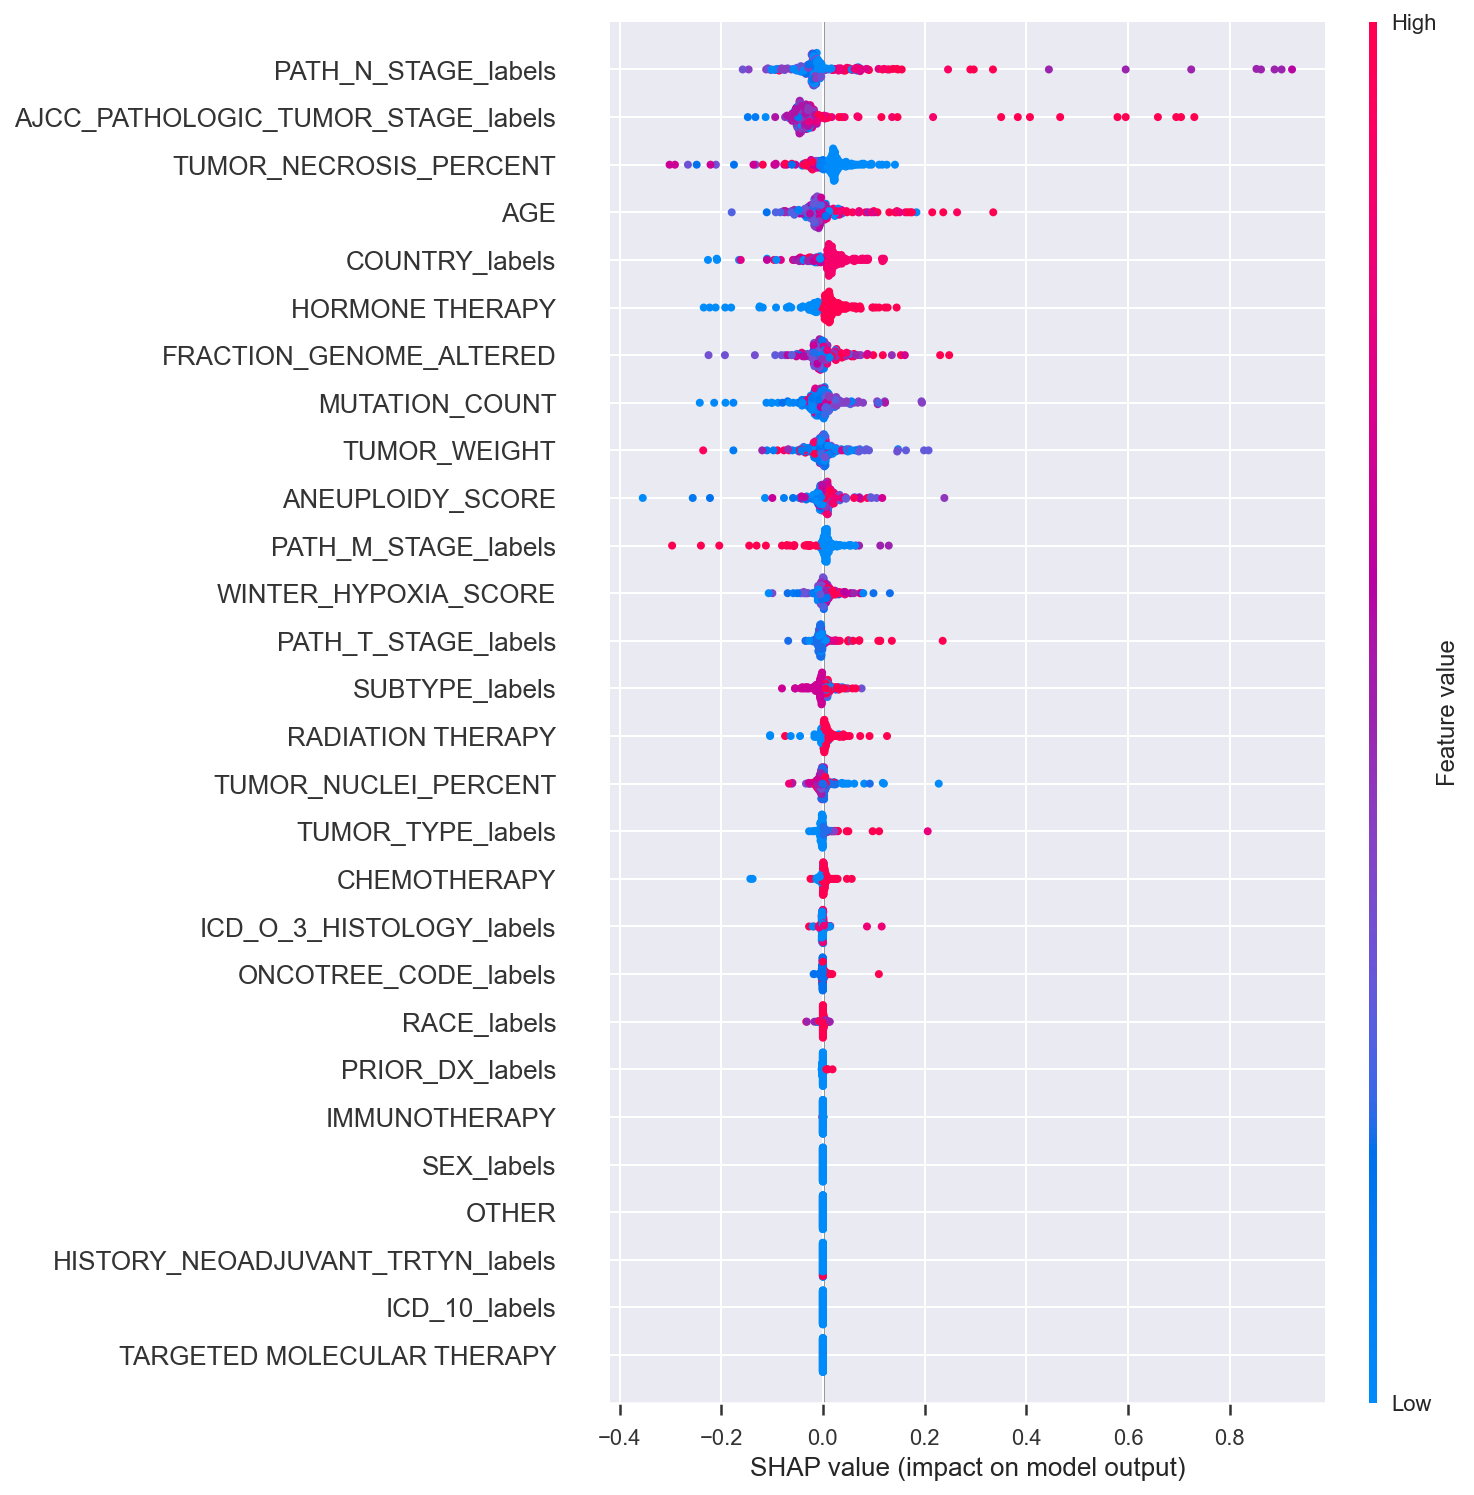

In [139]:
# Fits the explainer
explainer = shap.Explainer(estimator_xgb.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False, max_display=X.shape[1])